<a href="https://colab.research.google.com/github/asia281/dnn2022/blob/main/Asia_of_hw1_checkpoints_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpointing

Your task is to implement checkpointing for a MLP using NumPy.

You are free to use the implementation of a MLP and the backpropagation algorithm that you have developed during lab sessions.

The key takeaway from this task is that with checkpointing we can trade off the computational resources needed to compute the forward pass of the network for the memory requirement needed to perform a backward pass in the network, which is often a major bottleneck when training large networks. In plain english, we can slightly increase the time required for training our network to save some of our GPU's precious memory.

## What is checkpointing?

The aim of checkpointing is to save every $n$-th layer's (e.g. every 2-nd layer's) forward result (instead of saving every layer's forward result as in plain backpropagation) and use these checkpoints for recomputing the forward pass of the network upon doing a backward pass. Checkpoint layers are kept in memory after the forward pass, while the remaining activations are recomputed at most once. After being recomputed, the non-checkpoint layers are kept in memory until they are no longer required.

# What should be done

1. Take the implementation a MLP trained with backpropagation. Analyze the algorithm with respect to the memory that is used by the algorithm with respect to the number of hidden layers.

2. Implement a class NetworkWithCheckpointing that inherits from the Network class defined during lab sessions by:
    a) implementing a method `forward_between_checkpoints` that will recompute the forward pass of the network using one of the checkpointed layers
    b) override the method `backprop` to use only checkpointed layers and otherwise compute the activations using `forward_between_checkpoints` method and keep it in memory until no longer needed.

3. Train your network with checkpoinintg on MNIST. Compare running times and memory usage with respect to the network without checkpointing.


# Implement Checkpointing for a MLP

In [42]:
import random
import numpy as np
from torchvision import datasets, transforms

In [43]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-11-19 19:15:39--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.13, 52.216.242.118, 52.217.206.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  5.96MB/s    in 1.8s    

2022-11-19 19:15:41 (5.96 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [44]:
# Let's read the mnist dataset
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

# And assign the variables
(x_train, y_train), (x_test, y_test) = load_mnist()

In [45]:
# Declaration of sigmoid and softmax functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def softmax(z):
    exps = np.exp(z - np.max(z))
    sum = np.sum(exps, axis=0)
    res = exps / sum
    return res

In [46]:
import matplotlib.pyplot as plt

# Function to plot 
def plot_learning_curve(test_accs):
    xs = range(1, len(test_accs) + 1)
    plt.clf()
    plt.plot(xs, test_accs, label='test accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.grid()
    plt.legend()
    plt.show()

In my implementation of `Network`, I'm using SDG momentum, L2 regularization, as well as softmax as an activation for the last layer. In all the experiments I'm using `%time` to measure the time. I'm running network with almost all the same hyperparameters, changing only number of layers and how ofen to create checkpoints.

In [47]:
class Network(object):
    def __init__(self, sizes, l2=0.0, momentum=0.0):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.l2 = l2
        self.momentum = momentum
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.weights_momentum = [np.zeros_like(x) for x in self.weights]
        self.biases_momentum = [np.zeros_like(x) for x in self.biases]
    
    def activation(self, z, l):
        if l == (self.num_layers - 1):
            return softmax(z)

        return sigmoid(z)
    
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for l, b, w in zip(range(1, self.num_layers), self.biases, self.weights):
          a = self.activation(np.matmul(w, a)+b, l)
        return a
    
    def update_mini_batch(self, mini_batch, eta):
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)
        
        self.weights_momentum = [(self.momentum*wm)-(eta/len(mini_batch[0]))*nw 
                                 for wm, w, nw in zip(self.weights_momentum, self.weights, nabla_w)]
        self.biases_momentum = [(self.momentum*bm)-(eta/len(mini_batch[0]))*nb 
                                for bm, b, nb in zip(self.biases_momentum, self.biases, nabla_b)]
                            
        self.weights = [w+wm for w, wm in zip(self.weights, self.weights_momentum)]
        self.biases = [b+bm for b, bm in zip(self.biases, self.biases_momentum)]
        
    def backprop(self, x, y):
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for l, b, w in zip(range(1, self.num_layers), self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = self.activation(f, l)
            gs.append(g)
            
        dLdf = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for l,w,g in reversed(list(zip(range(1, self.num_layers), self.weights, gs[1:]))):
            if l < (self.num_layers - 1):
                dLdf = np.multiply(dLdg, np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)
        
        dLdWs = [np.matmul(dLdf,g.T) + (self.l2 * w) for dLdf, g, w in zip(reversed(dLdfs), gs[:-1], self.weights)] 
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] 

        return (dLdBs, dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accs = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accs.append(acc)
                print("Epoch: {0}, Accuracy: {1}".format(j, acc))
            else:
                print("Epoch: {0}".format(j))
        plot_learning_curve(accs)

Epoch: 0, Accuracy: 0.9006
Epoch: 1, Accuracy: 0.924
Epoch: 2, Accuracy: 0.9315
Epoch: 3, Accuracy: 0.9367
Epoch: 4, Accuracy: 0.9343
Epoch: 5, Accuracy: 0.9358
Epoch: 6, Accuracy: 0.9387
Epoch: 7, Accuracy: 0.9408
Epoch: 8, Accuracy: 0.9431
Epoch: 9, Accuracy: 0.9451
Epoch: 10, Accuracy: 0.9437
Epoch: 11, Accuracy: 0.9423
Epoch: 12, Accuracy: 0.9483
Epoch: 13, Accuracy: 0.9476
Epoch: 14, Accuracy: 0.9518
Epoch: 15, Accuracy: 0.9487
Epoch: 16, Accuracy: 0.9483
Epoch: 17, Accuracy: 0.9496
Epoch: 18, Accuracy: 0.9493
Epoch: 19, Accuracy: 0.9534


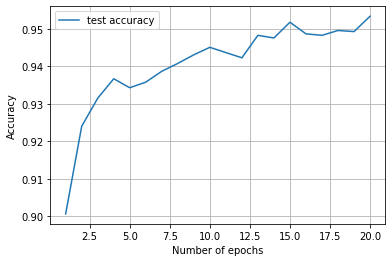

CPU times: user 33.2 s, sys: 13.8 s, total: 47 s
Wall time: 24.4 s


In [48]:
network = Network([784,30,10], l2=0.001, momentum=0.7)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

NetworkWithCheckpointing is storing feedforward results only after checkpoint_every_nth_layer layer. The only function we changed is backprop, that uses forward_between_checkpoints function.
While forward pass, we save only some variables, to restore them for not saved indices, we use get function, that recursively computes variables between two checkpoints.
After using gs for idx % checkpoint_every_nth_layer != 0, we delete them.

In [49]:
class NetworkWithCheckpointing(Network):
    def __init__(self, sizes, checkpoint_every_nth_layer: int = 0, *args, **kwargs):
        super().__init__(sizes, *args, **kwargs)
        self.checkpoint_freq = checkpoint_every_nth_layer
        self.layers_nr = len(sizes)

    # Function to get an element from the dict that is computed recursively
    def get(self, d: dict, idx: int):
      if idx in d:
        return d[idx]
      mul = np.matmul(self.weights[idx - 1], self.get(d, idx - 1))
      d[idx] = sigmoid(mul + self.biases[idx - 1])
      return d[idx]

    def delete(self, d: dict, idx: int):
      if idx % self.checkpoint_freq != 0 and idx in d:
        del d[idx]

    def forward_between_checkpoints(self, a, start, end):
      is_last = (end == self.layers_nr - 1)
      if is_last:
        end -= 1
      for b, w in zip(self.biases[start:end], self.weights[start:end]):
        a = sigmoid(np.dot(w, a) + b)   
      if is_last:
        return softmax(np.matmul(self.weights[-1], a) + self.biases[-1])

      return a

    def backprop(self, x, y):
      gs = {}
      g = x
      gs[0] = g

      for i in range(0, self.layers_nr - 1, self.checkpoint_freq):
        end = min(self.layers_nr - 1, i + self.checkpoint_freq)
        g = self.forward_between_checkpoints(g, i, end)
        gs[end] = g
      # backward pass <- both steps at once
      idx = self.layers_nr - 1
      dLdf = self.cost_derivative(gs[idx], y)
      dLdfs = []
      dLdWs = []
      for idx, w in reversed(list(zip(range(1, self.num_layers), self.weights))):
        if idx < (self.num_layers - 1):
          #Compute gs[idx]
          g = self.get(gs, idx)
          # Delete not necessary computed gs[idx]
          self.delete(gs, idx)
          dLdf = np.multiply(dLdg,np.multiply(g,1-g))

        dLdfs.append(dLdf)
        dLdg = np.matmul(w.T, dLdf)

      for idx, w in enumerate(reversed(dLdfs)):
        dLdWs.append(np.matmul(w, self.get(gs, idx).T))
        # Delete computed gs[idx]
        if idx > 0:
          del gs[idx-1]
      
      # Apply L2 regularization
      dLdWs = dLdWs + [self.l2 * w for w in self.weights]
      dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] 
      return (dLdBs, dLdWs)


Epoch: 0, Accuracy: 0.9004
Epoch: 1, Accuracy: 0.9213
Epoch: 2, Accuracy: 0.9285
Epoch: 3, Accuracy: 0.9326
Epoch: 4, Accuracy: 0.937
Epoch: 5, Accuracy: 0.9418
Epoch: 6, Accuracy: 0.9423
Epoch: 7, Accuracy: 0.9425
Epoch: 8, Accuracy: 0.9448
Epoch: 9, Accuracy: 0.946
Epoch: 10, Accuracy: 0.9477
Epoch: 11, Accuracy: 0.9492
Epoch: 12, Accuracy: 0.9501
Epoch: 13, Accuracy: 0.9501
Epoch: 14, Accuracy: 0.951
Epoch: 15, Accuracy: 0.9508
Epoch: 16, Accuracy: 0.9515
Epoch: 17, Accuracy: 0.9519
Epoch: 18, Accuracy: 0.9513
Epoch: 19, Accuracy: 0.9516


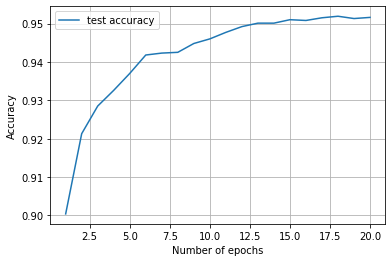

CPU times: user 48.9 s, sys: 18 s, total: 1min 6s
Wall time: 35 s


In [50]:
net_check = NetworkWithCheckpointing([784,30,10], 2)
%time net_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.9173
Epoch: 1, Accuracy: 0.933
Epoch: 2, Accuracy: 0.944
Epoch: 3, Accuracy: 0.9421
Epoch: 4, Accuracy: 0.9463
Epoch: 5, Accuracy: 0.9484
Epoch: 6, Accuracy: 0.9493
Epoch: 7, Accuracy: 0.9517
Epoch: 8, Accuracy: 0.9492
Epoch: 9, Accuracy: 0.9506
Epoch: 10, Accuracy: 0.9542
Epoch: 11, Accuracy: 0.9527
Epoch: 12, Accuracy: 0.9564
Epoch: 13, Accuracy: 0.9513
Epoch: 14, Accuracy: 0.9545
Epoch: 15, Accuracy: 0.953
Epoch: 16, Accuracy: 0.9575
Epoch: 17, Accuracy: 0.9556
Epoch: 18, Accuracy: 0.9481
Epoch: 19, Accuracy: 0.951


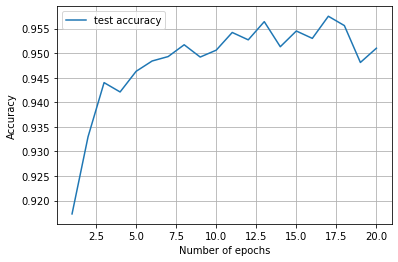

CPU times: user 33.2 s, sys: 16.7 s, total: 49.9 s
Wall time: 31.1 s
Epoch: 0, Accuracy: 0.8983
Epoch: 1, Accuracy: 0.9273
Epoch: 2, Accuracy: 0.9348
Epoch: 3, Accuracy: 0.938
Epoch: 4, Accuracy: 0.9394
Epoch: 5, Accuracy: 0.94
Epoch: 6, Accuracy: 0.9391
Epoch: 7, Accuracy: 0.9383
Epoch: 8, Accuracy: 0.9401
Epoch: 9, Accuracy: 0.9393
Epoch: 10, Accuracy: 0.9416
Epoch: 11, Accuracy: 0.9436
Epoch: 12, Accuracy: 0.9425
Epoch: 13, Accuracy: 0.9446
Epoch: 14, Accuracy: 0.9437
Epoch: 15, Accuracy: 0.9405
Epoch: 16, Accuracy: 0.9425
Epoch: 17, Accuracy: 0.943
Epoch: 18, Accuracy: 0.9432
Epoch: 19, Accuracy: 0.9399


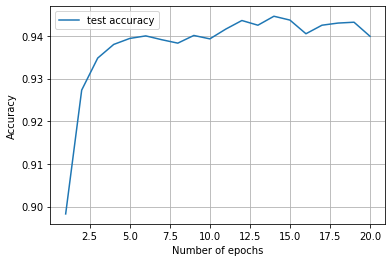

CPU times: user 33.8 s, sys: 20.1 s, total: 53.9 s
Wall time: 35.3 s


In [51]:
network = Network([784,30,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,30,10], 1, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8732
Epoch: 1, Accuracy: 0.9118
Epoch: 2, Accuracy: 0.925
Epoch: 3, Accuracy: 0.9287
Epoch: 4, Accuracy: 0.9317
Epoch: 5, Accuracy: 0.9289
Epoch: 6, Accuracy: 0.9411
Epoch: 7, Accuracy: 0.9366
Epoch: 8, Accuracy: 0.9461
Epoch: 9, Accuracy: 0.9411
Epoch: 10, Accuracy: 0.9399
Epoch: 11, Accuracy: 0.9475
Epoch: 12, Accuracy: 0.9469
Epoch: 13, Accuracy: 0.9388
Epoch: 14, Accuracy: 0.9409
Epoch: 15, Accuracy: 0.9483
Epoch: 16, Accuracy: 0.9466
Epoch: 17, Accuracy: 0.9473
Epoch: 18, Accuracy: 0.9512
Epoch: 19, Accuracy: 0.9469


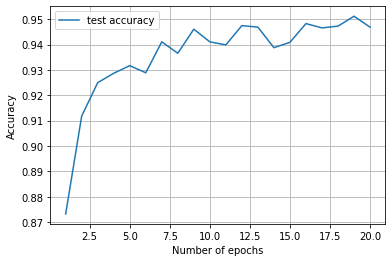

CPU times: user 43.9 s, sys: 44.6 s, total: 1min 28s
Wall time: 48.7 s
Epoch: 0, Accuracy: 0.9022
Epoch: 1, Accuracy: 0.9129
Epoch: 2, Accuracy: 0.9253
Epoch: 3, Accuracy: 0.9306
Epoch: 4, Accuracy: 0.9365
Epoch: 5, Accuracy: 0.9393
Epoch: 6, Accuracy: 0.9446
Epoch: 7, Accuracy: 0.9371
Epoch: 8, Accuracy: 0.9492
Epoch: 9, Accuracy: 0.9461
Epoch: 10, Accuracy: 0.9474
Epoch: 11, Accuracy: 0.9443
Epoch: 12, Accuracy: 0.9468
Epoch: 13, Accuracy: 0.9445
Epoch: 14, Accuracy: 0.948
Epoch: 15, Accuracy: 0.9457
Epoch: 16, Accuracy: 0.9448
Epoch: 17, Accuracy: 0.9496
Epoch: 18, Accuracy: 0.9478
Epoch: 19, Accuracy: 0.9484


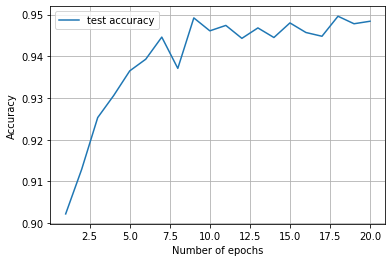

CPU times: user 56.1 s, sys: 1min 19s, total: 2min 15s
Wall time: 1min 24s


In [52]:
network = Network([784,30,30,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,30,30,10], 2, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.0974
Epoch: 1, Accuracy: 0.0974
Epoch: 2, Accuracy: 0.101
Epoch: 3, Accuracy: 0.2142
Epoch: 4, Accuracy: 0.8904
Epoch: 5, Accuracy: 0.9204
Epoch: 6, Accuracy: 0.9333
Epoch: 7, Accuracy: 0.9352
Epoch: 8, Accuracy: 0.9366
Epoch: 9, Accuracy: 0.948
Epoch: 10, Accuracy: 0.951
Epoch: 11, Accuracy: 0.9563
Epoch: 12, Accuracy: 0.9563
Epoch: 13, Accuracy: 0.9583
Epoch: 14, Accuracy: 0.9588
Epoch: 15, Accuracy: 0.9599
Epoch: 16, Accuracy: 0.9619
Epoch: 17, Accuracy: 0.9633
Epoch: 18, Accuracy: 0.9666
Epoch: 19, Accuracy: 0.9548


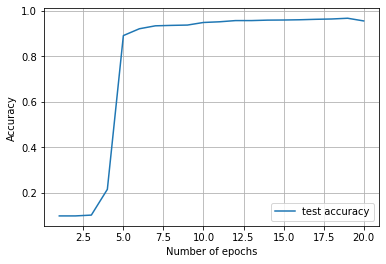

CPU times: user 1min 50s, sys: 1min 42s, total: 3min 33s
Wall time: 1min 53s
Epoch: 0, Accuracy: 0.0974
Epoch: 1, Accuracy: 0.2108
Epoch: 2, Accuracy: 0.5993
Epoch: 3, Accuracy: 0.8708
Epoch: 4, Accuracy: 0.8895
Epoch: 5, Accuracy: 0.9038
Epoch: 6, Accuracy: 0.9259
Epoch: 7, Accuracy: 0.9354
Epoch: 8, Accuracy: 0.9339
Epoch: 9, Accuracy: 0.9447
Epoch: 10, Accuracy: 0.9441
Epoch: 11, Accuracy: 0.9462
Epoch: 12, Accuracy: 0.9444
Epoch: 13, Accuracy: 0.9486
Epoch: 14, Accuracy: 0.9513
Epoch: 15, Accuracy: 0.9533
Epoch: 16, Accuracy: 0.9504
Epoch: 17, Accuracy: 0.9563


In [ ]:
network = Network([784,100,80,50,20,10], l2=0.001, momentum=0.6)
%time network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

network_check = NetworkWithCheckpointing([784,100,80,50,20,10], 3, l2=0.001, momentum=0.6)
%time network_check.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

During classes we were said to compute the memory usage only theoretically. 
Let `c := checkpoint_every_nth_layer` and `n := number_of_layers` and `freq := n/c`.

We want to estimate, what's the difference in the memory usage between  `Network` and `NetworkWithCheckpointing`. As we see, in `NetworkWithCheckpointing` we store values of forward steps after activation in `gs` that is a dictionary, not an array. In `gs` we are not storing all the valus, but one every `c`-th layer. The dict with k elements uses `O(k log k)` memory. Let s = memory usage of results of forward step for one layer. In  `Network` we use `O(ns)` memory to store these variables, in `NetworkWithCheckpointing` that memory usage is decreased to `O(freq log freq * s)`.

